In [1]:
import os
import pathlib
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import anguilla.hypervolume as hv
from anguilla.fitness import benchmark
from anguilla.evaluation import load_logs
from anguilla.dominance import NonDominatedSet2D, NonDominatedSetKD

In [2]:
FNS_2D = [
    ('ZDT1', benchmark.ZDT1(5)),
    ('ZDT2', benchmark.ZDT2(5)),
    ('ZDT3', benchmark.ZDT3(5)),
    ('ZDT4', benchmark.ZDT4(5)),
    ('ZDT6', benchmark.ZDT6(5)),
    ('IHR1', benchmark.IHR1(5)),
    ('IHR2', benchmark.IHR2(5)),
    ('IHR3', benchmark.IHR3(5)),
    ('IHR4', benchmark.IHR4(5)),
    ('IHR6', benchmark.IHR6(5)),
    ('ELLI1', benchmark.ELLI1(5)),
    ('ELLI2', benchmark.ELLI2(5)),
    ('CIGTAB1', benchmark.CIGTAB1(5)),
    ('CIGTAB2', benchmark.CIGTAB2(5)),
]

FNS_3D = [
    ('DTLZ1', benchmark.DTLZ1(5, 2)),
    ('DTLZ2', benchmark.DTLZ2(5, 2)),
    ('DTLZ3', benchmark.DTLZ3(5, 2)),
    ('DTLZ4', benchmark.DTLZ4(5, 2)),
    ('DTLZ5', benchmark.DTLZ5(5, 2)),
    ('DTLZ6', benchmark.DTLZ6(5, 2)),
    ('DTLZ7', benchmark.DTLZ7(5, 2)),
    #('GELLI3', benchmark.GELLI(5, 3)),
]

OPTS = [
    #'(100+1)-MO-CMA-ES-I',
    #'(100+1)-MO-CMA-ES-P',
    '(100+100)-MO-CMA-ES-I',
    '(100+100)-MO-CMA-ES-P',
    'NSGAII',
]

In [3]:
def plot_3d(best, worst, median, pareto_front=None, title=None):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(worst[:, 0], worst[:, 1], worst[:, 2], marker="x", color="red", zorder=1, label="Worst HVI")
    ax.scatter(median[:, 0], median[:, 1], median[:, 2], marker="x", color="orange", zorder=1, label="Median HVI")
    ax.scatter(best[:, 0], best[:, 1], best[:, 2], marker="x", color="green", zorder=1, label="Best HVI")
    if pareto_front is not None:
        ax.scatter(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2], marker="o", color="purple", zorder=2, label="True", alpha=0.2)
    ax.legend()
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel("First objective")
    ax.set_ylabel("Second objective")
    ax.set_zlabel("Third objective")
    fig.tight_layout()
    return fig

def plot_2d(best, worst, median, pareto_front=None, title=None):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.plot(worst[:, 0], worst[:, 1], marker="x", linestyle="", color="red", zorder=1, label="Worst HVI")
    ax.plot(median[:, 0], median[:, 1], marker="x", linestyle="", color="orange", zorder=1, label="Median HVI")
    ax.plot(best[:, 0], best[:, 1], marker="x", linestyle="", color="green", zorder=1, label="Best HVI")
    if pareto_front is not None:
        ax.plot(pareto_front[:, 0], pareto_front[:, 1], marker="", color="purple", zorder=2, label="True")
    ax.legend()
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel("First objective")
    ax.set_ylabel("Second objective")
    fig.tight_layout()
    return fig

def compute_reference_point(logs):
    n_logs = len(logs)
    n_objectives = logs[0].data.shape[1]
    point_set = NonDominatedSet2D() if n_objectives == 2 else NonDominatedSetKD()
    for i, log in enumerate(logs):
        clear_output(wait=True)
        display(f"[{i}/{n_logs} - {i/n_logs:.2%}] {log.fn}/{log.optimizer}/{log.trial}/{log.n_evaluations} {log.data.shape}")
        point_set.insert(log.data)
    reference = point_set.upper_bound + 1.0
    return reference

def plot_population(logs, pareto_front=None, name=""):
    # Assumes logs contain a single function - optimizer pair
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    data = {}
    key = None
    reference = compute_reference_point(logs)
    clear_output(wait=True)
    display("Reference point: ", reference)
    values = [hv.calculate(log.data, reference, ignore_dominated=True) for log in logs]
    ranks = np.argsort(values)
    best = logs[ranks[-1]]
    worst = logs[ranks[0]]
    median = logs[ranks[len(ranks) // 2]]    
    title = f"{name}\n{best.optimizer} with {best.fn} ({best.n_evaluations} evaluations)"
    if len(reference) == 3:
        return plot_3d(best.data, worst.data, median.data, pareto_front=pareto_front, title=title)
    return plot_2d(best.data, worst.data, median.data, pareto_front=pareto_front, title=title)

def generate_pareto_front(path, fn):
    if fn.has_known_pareto_front:
        display(f"Saving {fn.name}...")
        pareto_front = fn.pareto_front().T
        np.savetxt(path.joinpath(f"{fn.name}.txt"), pareto_front)

Generate 2D front text files

In [4]:
for (fn, fn_obj) in FNS_2D + FNS_3D:
    generate_pareto_front(pathlib.Path("./data/fronts"), fn_obj)

'Saving ZDT1...'

'Saving ZDT2...'

'Saving ZDT3...'

'Saving ZDT4...'

'Saving ZDT6...'

'Saving DTLZ1...'

'Saving DTLZ2...'

'Saving DTLZ3...'

'Saving DTLZ4...'

'Saving DTLZ7...'

Plot the populations using the logs generated with Anguilla

'Reference point: '

array([1.85939962, 5.        ])

'Processing DTLZ7/NSGAII...'

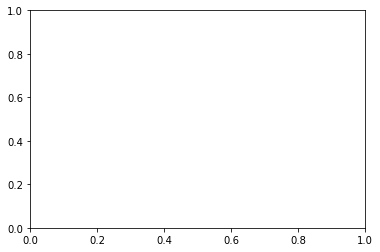

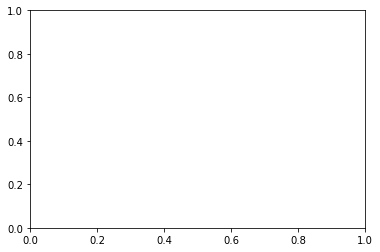

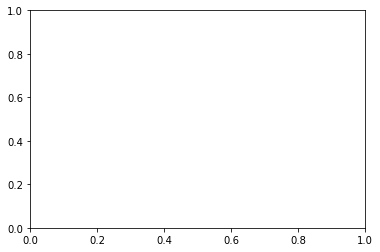

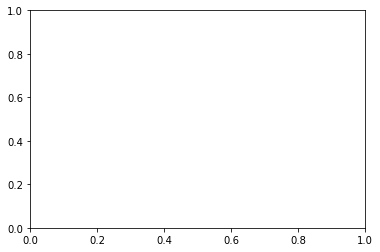

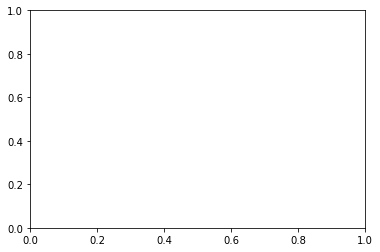

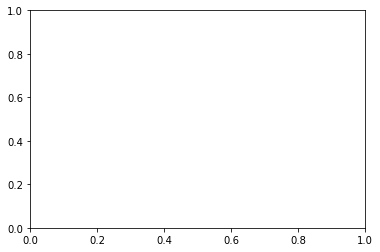

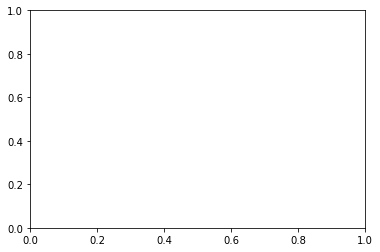

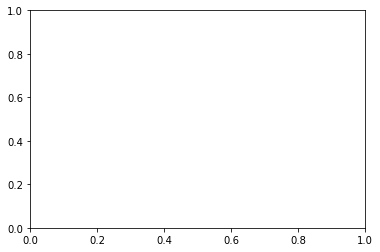

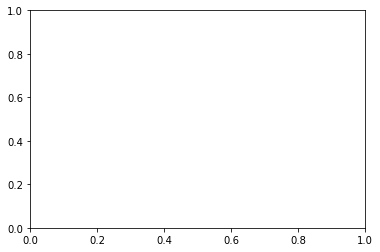

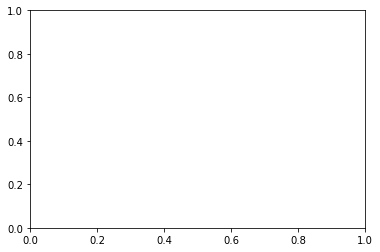

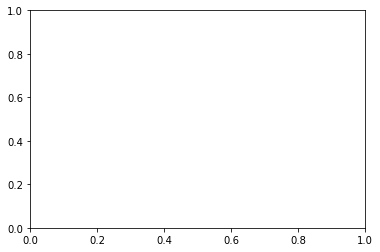

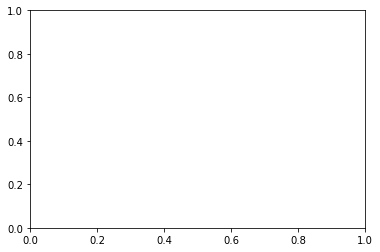

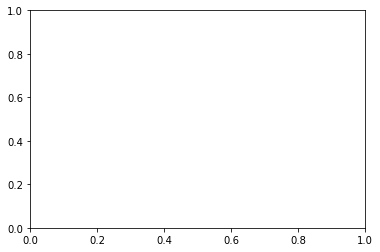

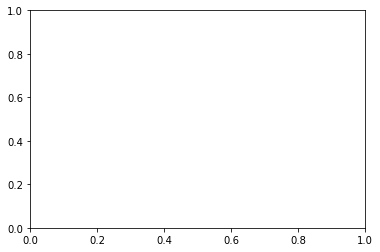

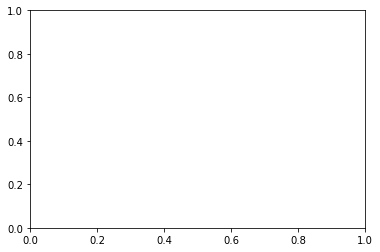

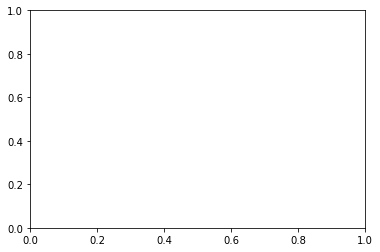

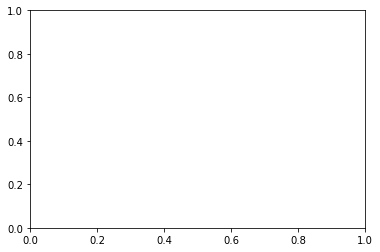

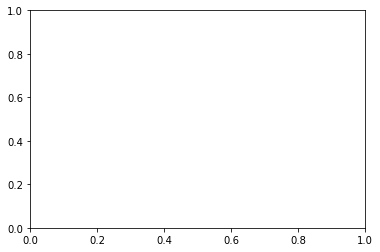

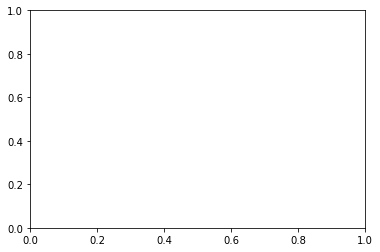

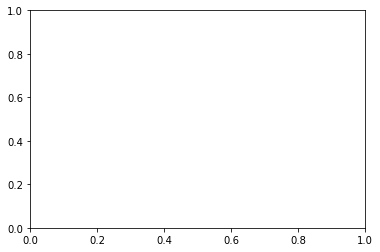

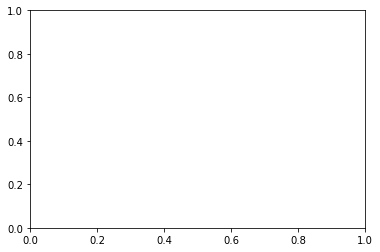

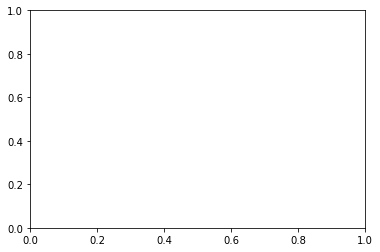

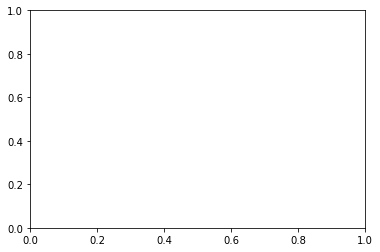

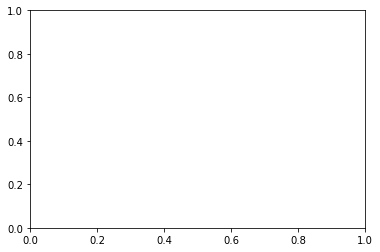

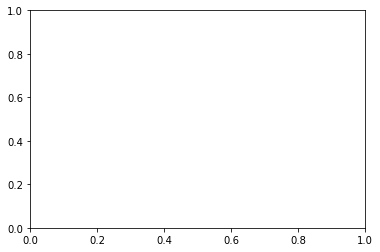

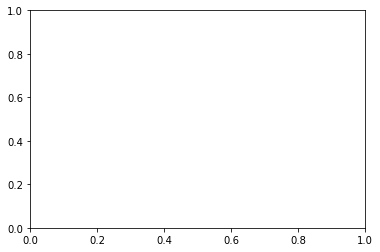

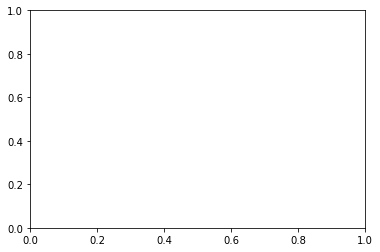

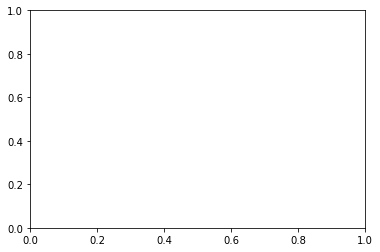

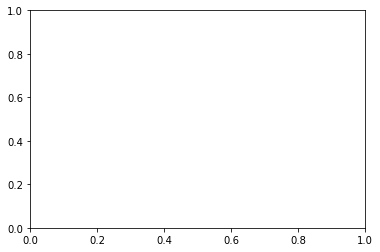

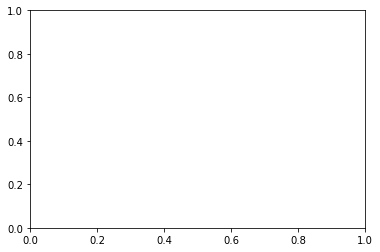

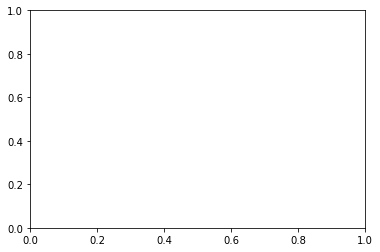

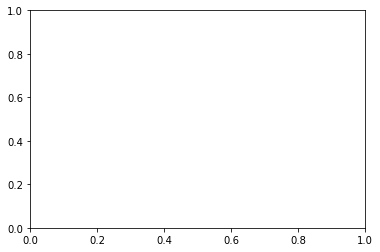

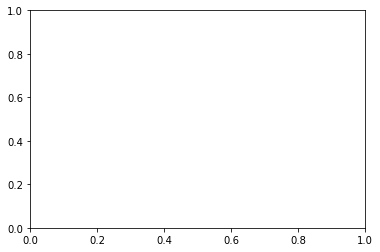

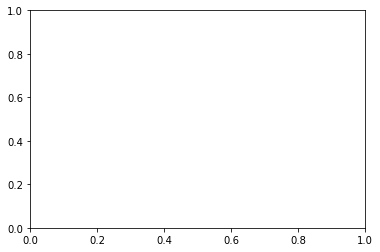

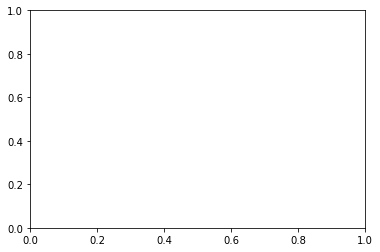

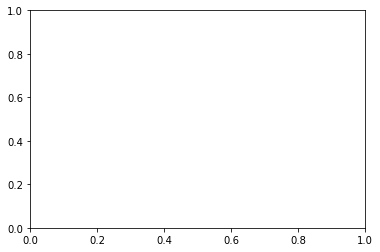

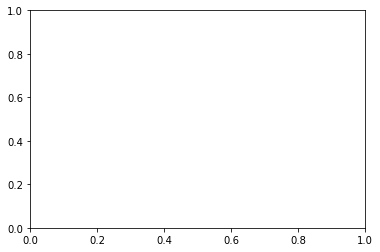

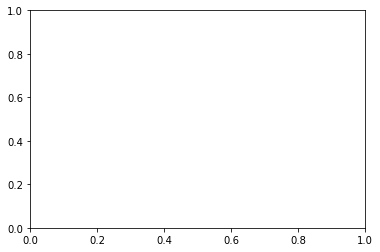

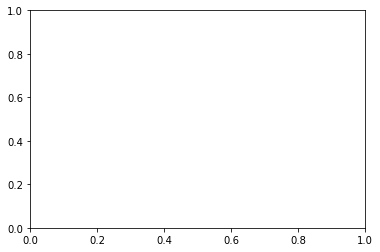

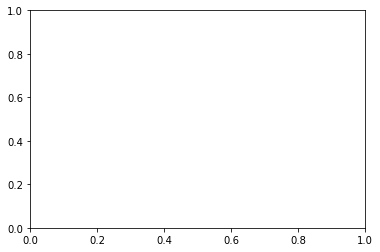

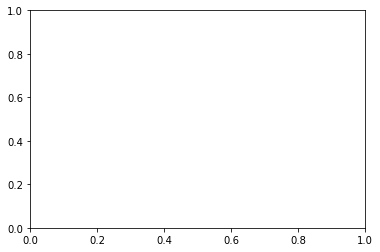

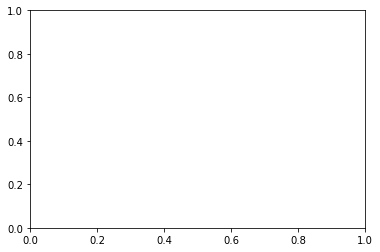

In [6]:
for (fn, _), opt in product(FNS_2D + FNS_3D, OPTS):
    display(f"Processing {fn}/{opt}...")
    path = pathlib.Path("./plots/fronts/anguilla-v020")
    if not path.exists():
        os.makedirs(path, exist_ok=True)
    logs = load_logs("./data/anguilla-v020", fns=[fn], opts=[opt], n_evaluations=[50000], observations=["fitness"], search_subdirs=True)
    if len(logs) > 0:
        pareto_front = None
        front_path = pathlib.Path(f"./data/fronts/{fn}.txt")
        if front_path.exists():
            pareto_front = np.loadtxt(front_path)
        fig = plot_population(logs, pareto_front, "Anguilla (v0.0.20)")
        fig.savefig(path.joinpath(f"{fn}-{opt}.pdf"), bbox_inches="tight")
        fig.savefig(path.joinpath(f"{fn}-{opt}.png"), bbox_inches="tight")
        plt.close(fig)

Plot the populations using the logs generated with Shark

'Reference point: '

array([1.85941586, 5.        ])

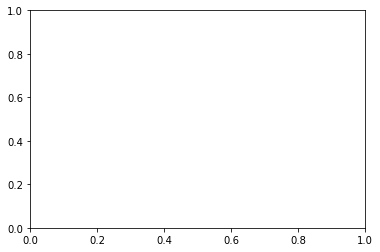

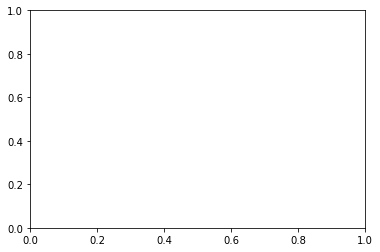

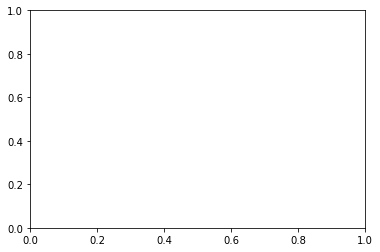

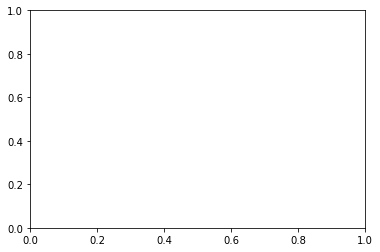

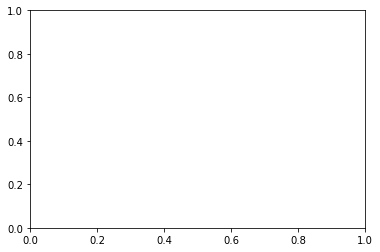

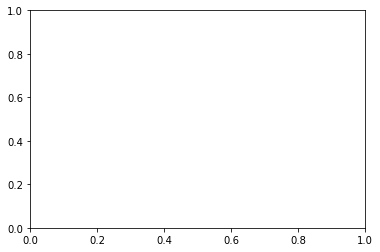

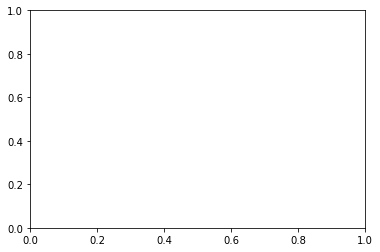

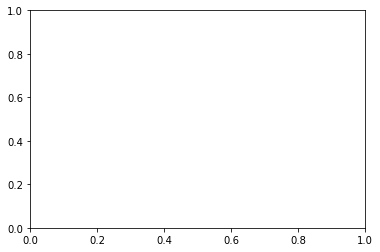

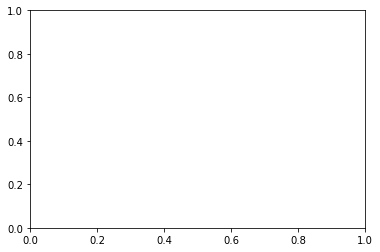

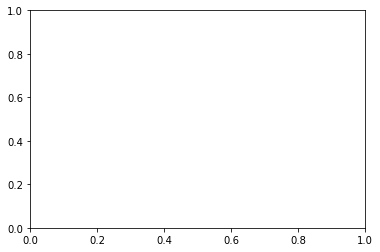

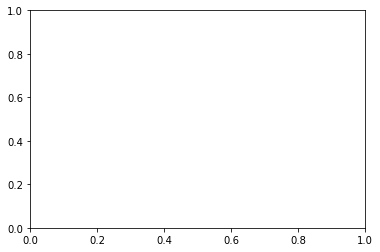

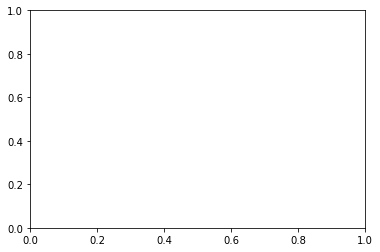

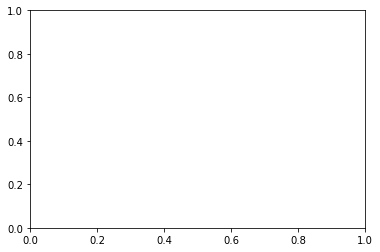

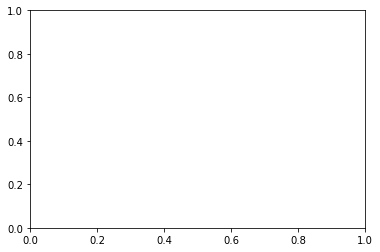

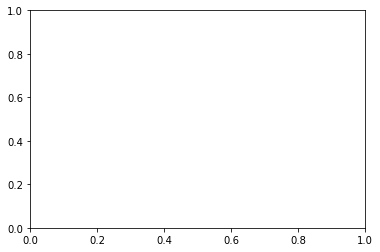

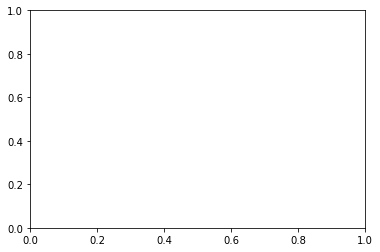

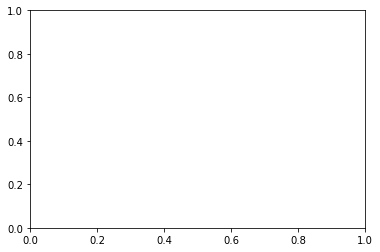

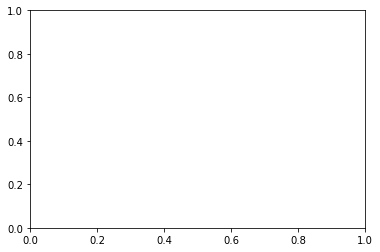

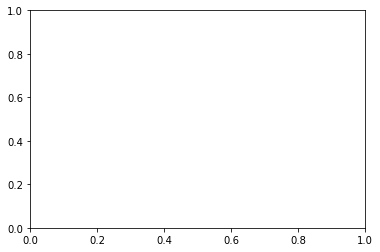

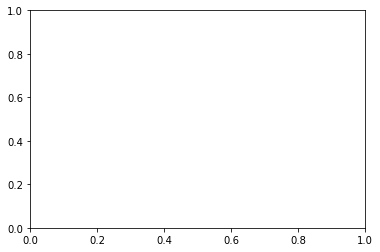

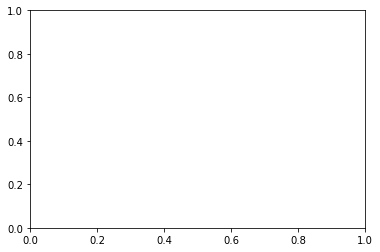

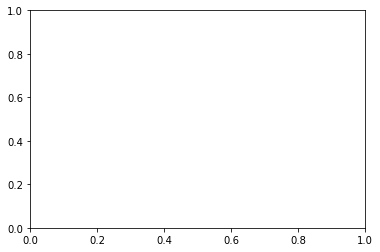

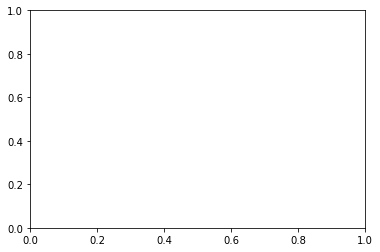

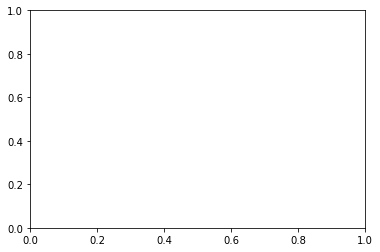

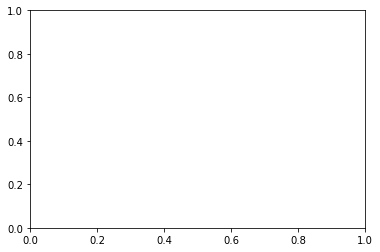

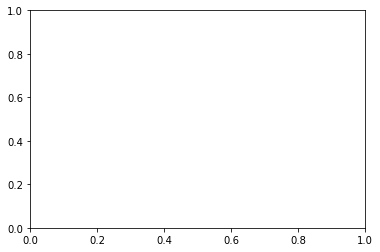

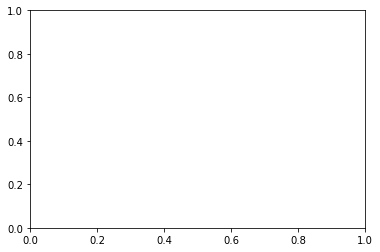

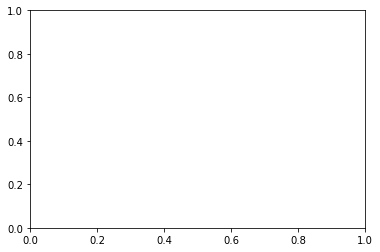

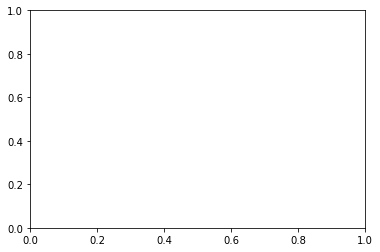

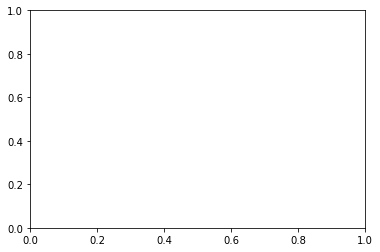

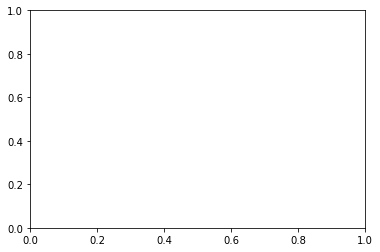

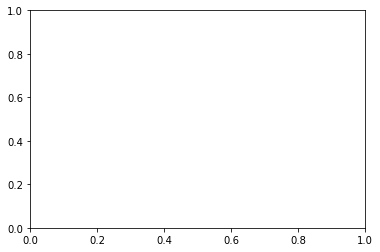

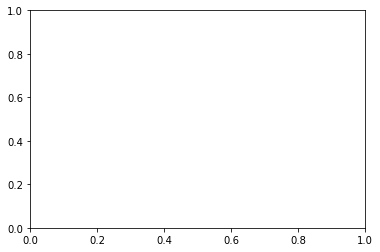

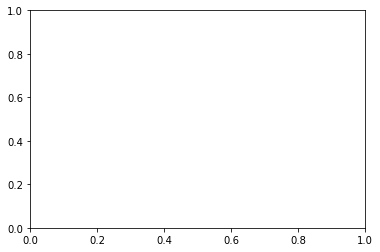

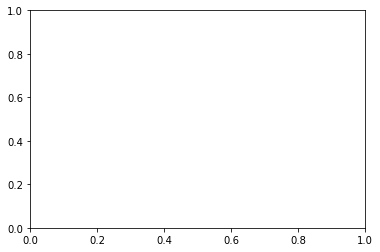

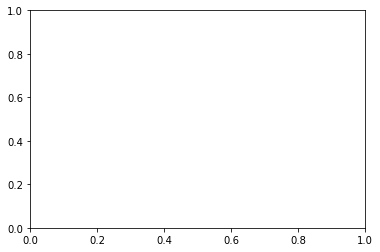

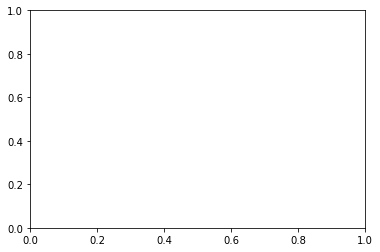

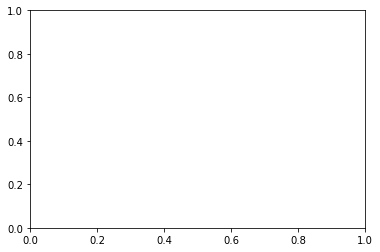

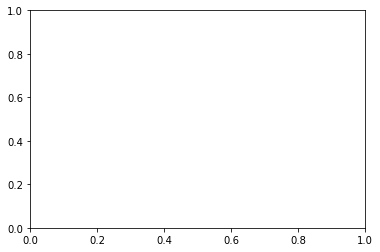

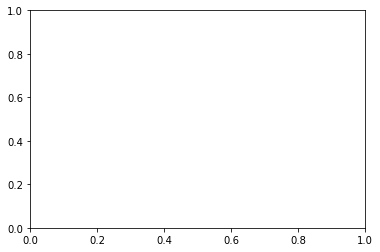

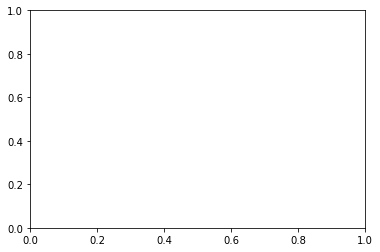

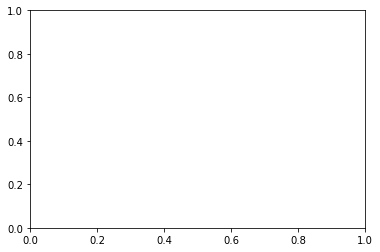

In [7]:
for (fn, _), opt in product(FNS_2D + FNS_3D, OPTS[:-1]):
    display(f"Processing {fn}/{opt}...")
    path = pathlib.Path("./plots/fronts/shark-patched-v1")
    if not path.exists():
        os.makedirs(path, exist_ok=True)
    logs = load_logs("./data/shark-patched-v1", fns=[fn], opts=[opt], n_evaluations=[50000], observations=["fitness"], search_subdirs=False)
    if len(logs) > 0:
        pareto_front = None
        front_path = pathlib.Path(f"./data/fronts/{fn}.txt")
        if front_path.exists():
            pareto_front = np.loadtxt(front_path)
        fig = plot_population(logs, pareto_front, "Shark (mod)")
        fig.savefig(path.joinpath(f"{fn}-{opt}.pdf"), bbox_inches="tight")
        fig.savefig(path.joinpath(f"{fn}-{opt}.png"), bbox_inches="tight")
        plt.close(fig)